In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import os
from PIL import Image
import numpy as np
import json
from collections import defaultdict

In [2]:
TARGET_CATEGORIES = [1, 2, 3, 4, 5, 6]  # mutually exclusive

In [3]:
class DeepFashionDataset(Dataset):
    def __init__(self, split, photo_transform=None, cloth_transform=None):
        self.path = f'../datasets/DeepFashion/{split}'
        
        self.photo_transform = photo_transform
        self.cloth_transform = cloth_transform
        
        self.objects = [x[:6] for x in os.listdir(f'{self.path}/centred_clothes')]
        
        self.idx_to_cat = np.zeros(len(self.objects))
        self.cat_to_idx = defaultdict(list)
        
        for i, oid in enumerate(self.objects):
            annot = json.load(open(f'{self.path}/annos/{oid}.json'))
            cat = self._get_cat_from_annot(annot)
            self.idx_to_cat[i] = cat
            self.cat_to_idx[cat].append(i)
            
    def _get_cat_from_annot(self, annot):
        for k, v in annot.items():
            if k.startswith('item') and v['category_id'] in TARGET_CATEGORIES:
                return v['category_id']
        
    def __len__(self):
        return len(self.objects)
    
    def _get_centred_cloth(self, idx):
        centred_cloth = Image.fromarray(np.load(f'{self.path}/centred_clothes/{self.objects[idx]}_cc.npy'))
        if self.cloth_transform:
            centred_cloth = self.cloth_transform(centred_cloth)
        return centred_cloth
            
            
    def __getitem__(self, idx):
        assert isinstance(idx, int)
        
        annot = json.load(open(f'{self.path}/annos/{self.objects[idx]}.json'))
        cat = self._get_cat_from_annot(annot)

        person_image = Image.open(f'{self.path}/image/{self.objects[idx]}.jpg')
        if self.photo_transform:
            person_image = self.photo_transform(person_image)

        mask = np.load(f'{self.path}/segmentation_masks/{self.objects[idx]}_mask.npy')
        
        rand_index = np.random.choice(len(self.cat_to_idx[cat]))
            
        return person_image, \
            mask, \
            self._get_centred_cloth(idx), \
            self._get_centred_cloth(self.cat_to_idx[cat][rand_index])

In [20]:
dataset = DeepFashionDataset('validation')

In [21]:
len(dataset)

9344

In [22]:
img1, mask1, cc1, cc2 = dataset[666]

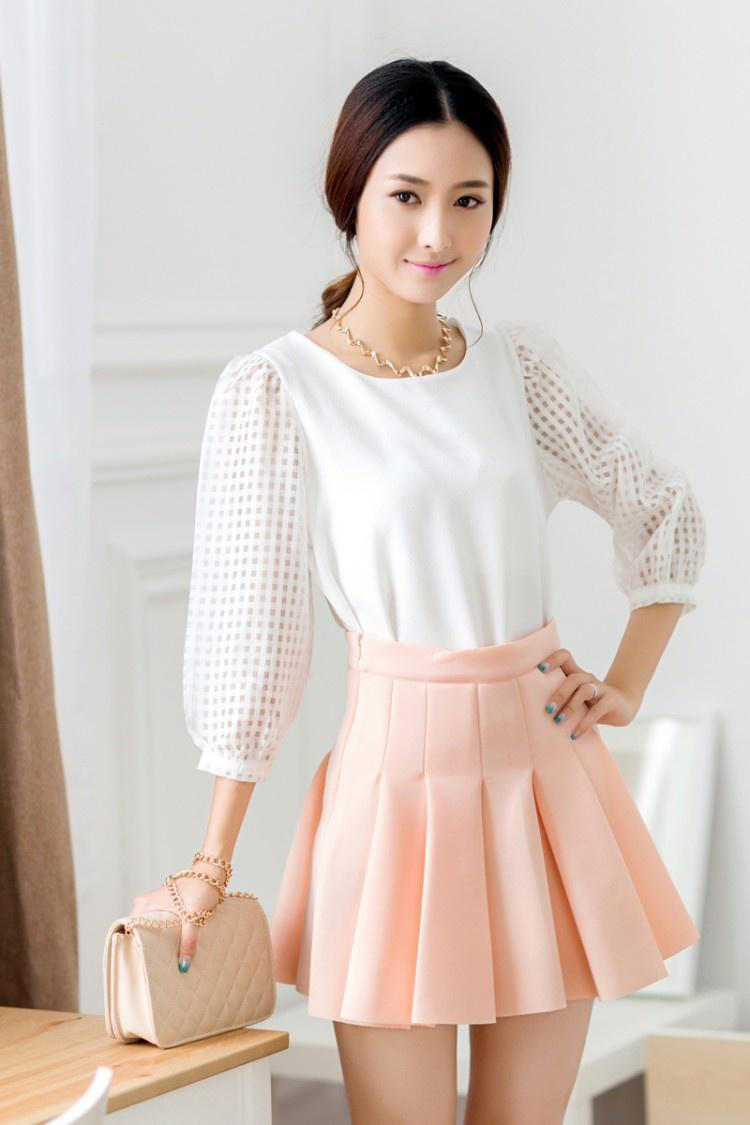

In [23]:
img1

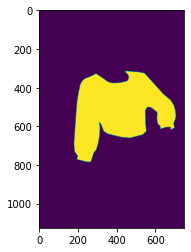

In [24]:
plt.imshow(mask1.astype(np.float));

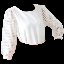

In [25]:
cc1

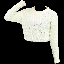

In [26]:
cc2